# Determinación de los parámetros de adquisición de una señal fisiológica

La medida de una magnitud física suele llevarse a cabo en la siguiente secuencia: transducción, muestreo y cuantización.

La transducción consiste en la conversión de la magnitud física (posición, ángulo, velocidad, presión, tensión mecánica, temperatura, etc.) en una señal de voltaje o intensidad, esto es, una señal eléctrica. El muestreo consiste en pasar de esa señal eléctrica que varía contínuamente en el tiempo, a una señal en paquetes de tiempo (valores promedios, por ejemplo), esto es, discreta en el tiempo. La cuantización consiste en pasar de estos valores de señal que pueden tomar valores arbitrariamente próximos entre ellos, a valores agrupados por tramos, esto es, que pueden tomar valores discretos o digitales.

Así, el resultado de una medida de una magnitud física continua o analógica se ha convertido en un listado digital de números enteros o, cuando menos, (a través de coeficientes multiplicativos de calibración) discretos, cada uno correspondiente a un tiempo de muestreo.

El objetivo de este ejercicio es que usted determine, a partir del análisis del archivo de datos proporcionado, procedente de una medida de presión intracardiaca con una tarjeta digitalizadora Keithley, cuáles fueron los settings de dicha tarjeta usados para la digitalización.

**TAREA**

En particular, deberá usted determinar:

- frecuencia de muestreo.
- frecuencia de Nyquist de la señal.
- bits de cuantificación.
- ganancia de la digitalización (factor multiplicador de calibración).
- polaridad de la medida (es decir, si la medida original era monopolar, esto es, sólo comprendía valores positivos de voltaje o si, por el contrario, era bipolar, esto es, comprendía valores tanto positivos como negativos de la señal eléctrica).
    
**DATOS**

Archivo de texto con dos columnas `1800031_PSentronMP.dat`; tiempo en segundos y presión calibrada en mmHg.

### Referencias

[Frecuencia de muestreo](https://es.wikipedia.org/wiki/Frecuencia_de_muestreo)

[Teorema de muestreo Numpy](https://ernestocrespo13.wordpress.com/2013/02/19/teorema-de-muestreo-explicado-con-numpy/)

[Muestreo, Cuantificacion, Codificacion](https://www.youtube.com/watch?v=9GxcNyGQsuk)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline
sns.set_theme(style="darkgrid")

# Data
DATA_PATH = "data/"

# Figures
FIGURES_PATH = "figures/"

df = pd.read_csv(
    DATA_PATH + "1_d1800031_PSentronMP.dat", 
    names=["seconds", "mmHg"]
)

df.head()

,seconds,mmHg
0,0.001,95.007489
1,0.002,95.007489
2,0.003,95.128993
3,0.004,95.250498
4,0.005,95.250498


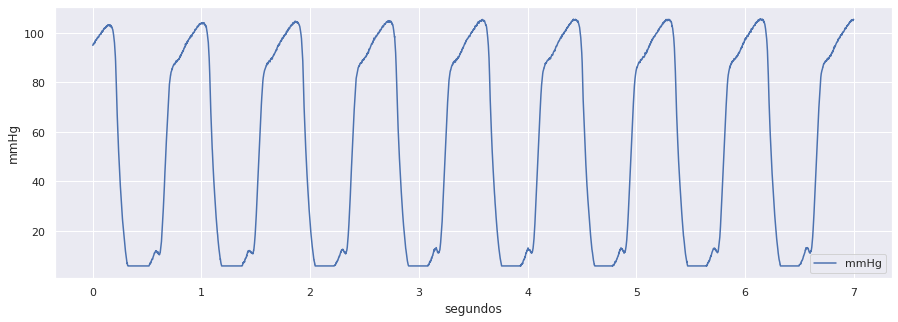

In [2]:
plt.figure(figsize = (15, 5))
plt.plot(df["seconds"], df["mmHg"], label="mmHg")
plt.xlabel("segundos")
plt.ylabel("mmHg")
plt.legend()
plt.grid(True)
plt.savefig(FIGURES_PATH + "plot_mmhg_vs_tiempo.png")
plt.show()

#### Frecuencias de muestreo

Será la inversa de nuestro paso de tiempo. En nuestro caso tenemos un muestreo uniforme (entre muestras consecutivas siempre hay la misma cantidad de tiempo).

In [3]:
intervalo_muestreo = df.loc[1, "seconds"] - df.loc[0, "seconds"]
f_muestreo = 1 / intervalo_muestreo

print("Intervalo de muestreo (s): ", intervalo_muestreo)
print("Frecuencia de muestreo (Hz): ", f_muestreo)

Intervalo de muestreo (s):  0.001
Frecuencia de muestreo (Hz):  1000.0


#### Frecuencia de Nyquist

El período (T) de nuestra muestra corresponde al tiempo que tarda la señal en dar una vuelta, esto es, dado un punto de la señal, el período será la diferencia de tiempo para el cual la señal vuelve a tomar dicho valor.

Con el objetivo de estimar el período de nuestra gráfica veamos los puntos para los cuales la presión coincide con nuestra primera muesta de datos (no es necesaria la primera muestra ya que se trata de una onda periódica y supondremos que habrá repetición debido a la gran cantidad de datos).

In [4]:
f_nyquist = f_muestreo / 2

print("Frecuencia de Nyquist (Hz): ", f_nyquist)

Frecuencia de Nyquist (Hz):  500.0


In [5]:
#df.loc[df["mmHg"] == df.loc[0, "mmHg"], ["seconds", "mmHg"]]
# df.loc[df["mmHg"] == df.loc[0, "mmHg"], "seconds"].index

In [6]:
#El período será la diferencia de tiempos consecutivos en nuestro anterior dataframe. Por ejemplo `(0.855 - 0.002)`. Es importante puntualizar que el período se encuentra alrededor del valor 0.852 ya que será necesario eliminar de nuestro cálculo aquellos valores de T que se alejen de este valor. Con estos datos podemos estimar la **frecuencia de Nyquist**.

In [7]:
#dn = df.loc[df["mmHg"] == df.loc[1000, "mmHg"], "seconds"]
#fn = []
#T = []

#for i in range(0, len(dn)-1):
#    T.append(dn[dn.index[i+1]] - dn[dn.index[i]])
#    if T[i] > 0.7 and T[i] < 1.0: # eliminar valores extraños
#        nyquist = 2 * 1/(T[i])
#        fn.append(nyquist)
#        print("Frecuencia de Nyquist estimada: ", nyquist)
#print(" ")        
#print("Frecuencia de Nyquist media: ", sum(fn)/len(fn))

#### Cuantificación

La cuantificación es el proceso por el cual establecemos una precisión en el eje vertival de la señal. Vendrá determinada por el número de valores únicos en el eje vertical.

En primer lugar ordenamos valores.

In [8]:
df_rl = df.sort_values(by="mmHg", ascending=True)
df_rl.head()

,seconds,mmHg
2987,2.988,5.823069
2194,2.195,5.823069
2195,2.196,5.823069
2196,2.197,5.823069
2197,2.198,5.823069


Eliminamos repetidos y creamos set de datos para próxima regresión lineal.

In [9]:
yu = df_rl["mmHg"].unique()
x = np.array(range(0, len(yu)))
xm = np.arange(0, 10, 10/len(yu)) # mapeo x a tensión rango 0-10

print("Niveles de cuantificación: ", len(yu))

Niveles de cuantificación:  766


#### Bits de cuantificación

A partir de la cuantificación aplicamos el logaritmo para estimar los bits.

In [10]:
bits = 2 ** np.array(range(0, 24))

# Dos métodos, debería dar el mismo resultado
print("Bits de cuatificación: ", np.log2([c for c in bits if c > len(yu)][0]))
print("Bits de cuatificación: ", np.ceil(np.log2(len(yu))))

Bits de cuatificación:  10.0
Bits de cuatificación:  10.0


#### Ganancia

Corresponde con la pendiente de la regresión lineal según la ecuación.

$$
mmHg = ganancia \cdot tension + B
$$

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.488e+06
Date:                Mon, 30 Aug 2021   Prob (F-statistic):               0.00
Time:                        19:11:41   Log-Likelihood:                -780.32
No. Observations:                 766   AIC:                             1565.
Df Residuals:                     764   BIC:                             1574.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5062      0.048     93.019      0.0

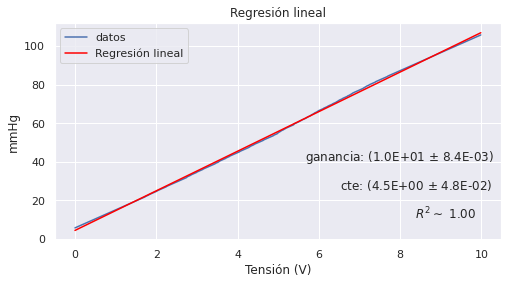

In [11]:
X = sm.add_constant(xm, prepend=True)

ols1 = sm.OLS(yu, X)
ols_result1 = ols1.fit()
print(ols_result1.summary())
print(" ")

y_pred = ols_result1.predict(X)

plt.figure(figsize = (8, 4))
plt.grid(True)
plt.plot(xm, yu, label="datos")
plt.plot(xm, y_pred, color="red", label="Regresión lineal")
plt.figtext(.56, .4, f"ganancia: (%.1E $\pm$ %.1E)" % (ols_result1.params[1], ols_result1.bse[1]))
plt.figtext(.62, .3, f"cte: (%.1E $\pm$ %.1E)" % (ols_result1.params[0], ols_result1.bse[0]))
plt.figtext(.75, .2, f"$R^2 \sim$ %.2f" % ols_result1.rsquared)
plt.title("Regresión lineal")
plt.xlabel("Tensión (V)")
plt.ylabel("mmHg")
plt.legend()
plt.savefig(FIGURES_PATH + "plot_regresion.png")
plt.show()

#### Polaridad

- Señal monopolar si todos los valores son positivos.

- Señal bipolar si hay valores negativos y positivos.

Hay que evaluar según coeficiente e intercepto de la regresión lineal.